In [97]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [98]:
from google.colab import auth
import gspread
from google.auth import default
#autenticating to google
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# Set Up

In [99]:
!apt-get install -y xvfb # Install X Virtual Frame Buffer
import os
os.system('Xvfb :1 -screen 0 1600x1200x16  &')  # start it
os.environ['DISPLAY']=':1.0'  # tells X clients where to connect to

Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.20.13-1ubuntu1~20.04.8).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [100]:
!pip install keybert
!pip install KeyBERT

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [101]:
import pandas as pd
import random
import copy
from keybert import KeyBERT
import nltk
import re
import csv
from nltk import word_tokenize
import gensim.downloader as api

# Key Word Extraction

In [102]:
# Using BERT model to get to most valuable word from the answer, in this case the catagory or the mechanism
sw = ['boardgames', 'boardgame', 'theme', 'game', 'games', 'themes', 'set', 'atmosphere', 'topic', 'topics', 'mechanisms', 'mechanism']
kw_model = KeyBERT()

def extract_keyword(input_user):
    all_keywords = kw_model.extract_keywords(input_user, stop_words=sw)
    return all_keywords[0][0]

In [103]:
def find_spelled_integers(sentence):
    # Define a dictionary to map spelled-out numbers to their corresponding integer values
    number_dict = {
        'zero': 0, 'one': 1, 'two': 2, 'three': 3, 'four': 4, 'five': 5, 'six': 6,
        'seven': 7, 'eight': 8, 'nine': 9, 'ten': 10, 'eleven': 11, 'twelve': 12,
        'thirteen': 13, 'fourteen': 14, 'fifteen': 15, 'sixteen': 16, 'seventeen': 17,
        'eighteen': 18, 'nineteen': 19, 'twenty': 20, 'thirty': 30, 'forty': 40,
        'fifty': 50, 'sixty': 60, 'seventy': 70, 'eighty': 80, 'ninety': 90,
        'hundred': 100, 'thousand': 1000
    }

    # Define a pattern to match spelled-out numbers
    pattern = r"\b(?:{})\b".format("|".join(number_dict.keys()))

    # Find all matches of spelled-out numbers in the sentence
    matches = re.findall(pattern, sentence, re.IGNORECASE)

    # Convert the spelled-out numbers to integers
    integers = [number_dict[match.lower()] for match in matches]

    # Remove duplicate integers
    integers = list(set(integers))

    return integers

def find_intergers(sentence):
    tok_input = nltk.tokenize.word_tokenize(sentence)
    nums = [int(word) for word in tok_input if word.isdigit()]
    return nums

def find_all_numbers(user_input):
    '''
    Returns a list with smallest number and biggest number the users' answer  
    '''
    lst1 = find_intergers(user_input)
    lst2 = find_spelled_integers(user_input)
    lst_nums = lst1+lst2
    if len(lst_nums) == 1:
        return [0, lst_nums[0]]
    else:
        return [min(lst_nums), max(lst_nums)]

# Similarity Comparison

In [104]:
import csv

category_list = []  
mechanism_list = []


f = open("/content/drive/MyDrive/Colab_Notebooks/data/categories.csv")
category_list = list(csv.reader(f))

#for some reason bayes_rating shows up twice in this list
category_list.remove(['bayes_rating'])
category_list.remove(['bayes_rating'])

f.close


f = open("/content/drive/MyDrive/Colab_Notebooks/data/mechanisms.csv")
mechanism_list = list(csv.reader(f))

mechanism_list.remove(['bayes_rating'])
mechanism_list.remove(['rating'])

f.close

def lowercase (lst):
  new_lst = []
  for item in lst:
    temp_item = []
    for word in item:
      temp = word.lower()
      temp_item.append(temp)
    new_lst.append(temp_item)
  
  return new_lst

cat_list_lower = lowercase(category_list)
mech_list_lower = lowercase(mechanism_list)


In [105]:
import nltk
from nltk import word_tokenize
nltk.download("punkt")
nltk.download("stopwords")
from nltk.stem import WordNetLemmatizer
import re

stops = set(nltk.corpus.stopwords.words('english'))
common_tokens = ['game', 'games', ':', "'s",]


def tokenize (feature_list):
  
  temp_list = []

  for item in feature_list:
    word = item[0].replace('/', ' ')
    word = word.replace('-', ' ')
    word = word.replace('Minimap', 'mini map')
    
    temp_tokens = word_tokenize(word.lower())
    filtered = [w for w in temp_tokens 
                if not w in stops 
                and not w in common_tokens]

    temp_list.append(filtered)

  return temp_list


clean_cat = tokenize(category_list)
clean_mech = tokenize(mechanism_list)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [106]:
from gensim.models import Word2Vec, KeyedVectors
import pandas as pd
import gensim.downloader as api
wv = api.load('glove-wiki-gigaword-100') 

In [107]:
def user_to_features (feature_list, user_input, dataform_list):
  
  sim_list = []

  for feature in feature_list:
    average = 0
    for word in feature:
      try:
        sim_val = wv.similarity(word, user_input)
        average = average + sim_val
      except:
        average = 0

    average = average / len(feature)
    temp_tuple = (feature, average)
    sim_list.append(temp_tuple)
        
  sim_df = pd.DataFrame(sim_list, columns = ['word', 'sim']) 
  sim_df = sim_df.sort_values(by=['sim'], ascending=False)

  index = sim_df.index[0]

  stats = sim_df
  #print(stats)

  return dataform_list[index]

# Find Board Game

# Import User Data from Form

In [108]:
import pandas as pd
#defining my worksheet
worksheet = gc.open('Board Game Recommender Survey (Responses)').sheet1
#get_all_values gives a list of rows
rows = worksheet.get_all_values()
#Convert to a DataFrame 
df = pd.DataFrame(rows)

#creating columns name
df.columns = df.iloc[0]
df = df.iloc[1:]

In [109]:
print(df.head)

<bound method NDFrame.head of 0            Timestamp                Email Address  \
1   5/26/2023 17:17:52             schat160@umm.edu   
2   5/26/2023 18:02:07      joshdfrench@outlook.com   
3    5/27/2023 0:14:40     patrickdysart2@gmail.com   
4    5/27/2023 0:16:09             booth250@umn.edu   
5    5/27/2023 0:31:35     gerardtheplant@gmail.com   
6    5/27/2023 0:40:24             pusch030@umn.edu   
7    5/27/2023 1:37:12         smgiinthir@gmail.com   
8    5/27/2023 5:52:15             silve490@umn.edu   
9   5/28/2023 12:50:15         bejczyvera@gmail.com   
10  5/28/2023 12:52:39  06-squad.protein@icloud.com   
11  5/28/2023 12:56:27     emma.beukers@hotmail.com   
12  5/28/2023 12:59:28   mathildepaquet19@gmail.com   
13  5/28/2023 13:00:56           clopro15@gmail.com   
14  5/28/2023 13:11:55        kjsdenotter@gmail.com   
15  5/28/2023 13:15:07  gayatri.srikant18@gmail.com   
16  5/28/2023 13:27:37    MateoAbrahami@outlook.com   
17  5/28/2023 13:46:26       sebast

# Processing User Inputs

In [110]:
df.columns = ["timestamp",
              "email",
              "q1_sent",
              "q2_sent",
              "q3_sent",
              "q4_sent",
              "q5_sent",
              "q1_word",
              "q2_word",
              "q3_word",
              "q4_minplay",
              "q4_maxplay",
              "q5_mintime",
              "q5_maxtime"]

In [111]:
lst = []

for column in df.columns:
  temp_lst = df[column].tolist()
  lst.append(temp_lst)

print(lst)

[['5/26/2023 17:17:52', '5/26/2023 18:02:07', '5/27/2023 0:14:40', '5/27/2023 0:16:09', '5/27/2023 0:31:35', '5/27/2023 0:40:24', '5/27/2023 1:37:12', '5/27/2023 5:52:15', '5/28/2023 12:50:15', '5/28/2023 12:52:39', '5/28/2023 12:56:27', '5/28/2023 12:59:28', '5/28/2023 13:00:56', '5/28/2023 13:11:55', '5/28/2023 13:15:07', '5/28/2023 13:27:37', '5/28/2023 13:46:26', '5/28/2023 14:11:54', '5/28/2023 15:23:18', '5/28/2023 15:53:07', '5/28/2023 18:02:07'], ['schat160@umm.edu', 'joshdfrench@outlook.com', 'patrickdysart2@gmail.com', 'booth250@umn.edu', 'gerardtheplant@gmail.com', 'pusch030@umn.edu', 'smgiinthir@gmail.com', 'silve490@umn.edu', 'bejczyvera@gmail.com', '06-squad.protein@icloud.com', 'emma.beukers@hotmail.com', 'mathildepaquet19@gmail.com', 'clopro15@gmail.com', 'kjsdenotter@gmail.com', 'gayatri.srikant18@gmail.com', 'MateoAbrahami@outlook.com', 'sebastian@backtalk.com', 'laurehajislam7@gmail.com', 'paulavermaas@gmail.com', 'leihabinger@gmail.com', 'cvillar1@fordham.edu'], ['T

In [112]:
def create_pairs(keyword_list, user_keyword_list):
  temp_lst = []
  i = 0
  while i < len(keyword_list):
    word = extract_keyword(keyword_list[i])
    temp_pair = (word, (word_tokenize(user_keyword_list[i].lower())[0]))
    temp_lst.append(temp_pair)
    i = i + 1

  return temp_lst

print(create_pairs(lst[2], lst[7]))


[('trains', 'trains'), ('classical', 'classical'), ('fantasy', 'medieval'), ('medieval', 'medieval'), ('castles', 'medieval'), ('spooky', 'horror'), ('space', 'space'), ('speak', 'tavern'), ('flowers', 'flowers'), ('nature', 'nature'), ('fantasy', 'fantasy'), ('fantasy', 'fantasy'), ('futuristic', 'futuristic'), ('forest', 'forrest'), ('setting', 'none'), ('land', 'fantasy'), ('fantasy', 'fantasy'), ('monarchy', 'monarchy'), ('city', 'city'), ('cartoon', 'cartoon'), ('space', 'space')]


In [113]:
def min_max_pairs(finder_list, min_list, max_list):
  return true


In [118]:
def compare(feature_list, pair_list, dataform_list):
  lst = []
  for pair in pair_list:
    temp = []
    for item in pair:
      word = user_to_features(feature_list, item, dataform_list)
      temp.append(word[0])
    lst.append(temp)

  return lst
    

In [115]:
def simple_sim(pair_list):
  sim_list = []
  for pair in pair_list:
    sim = wv.similarity(pair[0], pair[1])
    sim_list.append(sim)
  
  return sim_list

In [116]:
pairs = create_pairs(lst[2], lst[7])

compare(clean_cat, pairs, cat_list_lower)

[['trains', 'trains'], ['music', 'music'], ['fantasy', 'medieval'], ['medieval', 'medieval'], ['medieval', 'medieval'], ['horror', 'horror'], ['space exploration', 'space exploration'], ['word game', 'family games'], ['animals', 'animals'], ['animals', 'animals'], ['fantasy', 'fantasy'], ['fantasy', 'fantasy'], ['fantasy', 'fantasy'], ['farming', 'fantasy'], ['city building', 'number'], ['territory building', 'fantasy'], ['fantasy', 'fantasy'], ['napoleonic', 'napoleonic'], ['city building', 'city building'], ['horror', 'horror'], ['space exploration', 'space exploration']]


In [123]:
def if_same(pair_list):
  same_list = []
  for pair in pair_list:
    if pair[0] == pair[1]:
      same_list.append(1)
    else: 
      same_list.append(0)
  return same_list

In [126]:
#Category 1
cat1_pairs = create_pairs(lst[2], lst[7])
keyword_sim_cat1 = simple_sim(cat1_pairs)
feature_cat1 = compare(clean_cat, cat1_pairs, cat_list_lower)
feature_same_cat1 = if_same(feature_cat1)

print(keyword_sim_cat1)
print(feature_cat1)
print(feature_same_cat1)

#Category 2
cat2_pairs = create_pairs(lst[3], lst[8])
keyword_sim_cat2 = simple_sim(cat2_pairs)
feature_cat2 = compare(clean_cat, cat2_pairs, cat_list_lower)
feature_same_cat2 = if_same(feature_cat2)

#Mechanism
mech_pairs = create_pairs(lst[4], lst[9])
keyword_sim_mech = simple_sim(mech_pairs)
feature_mech = compare(clean_cat, mech_pairs, mech_list_lower)
feature_same_mech = if_same(feature_mech)



[1.0000001, 1.0, 0.37800744, 1.0, 0.6006654, 0.4482521, 1.0, 0.05259891, 1.0, 0.99999994, 1.0, 1.0, 1.0000001, 0.23127082, 0.4083722, 0.27068377, 1.0, 1.0, 1.0, 1.0, 1.0]
[['trains', 'trains'], ['music', 'music'], ['fantasy', 'medieval'], ['medieval', 'medieval'], ['medieval', 'medieval'], ['horror', 'horror'], ['space exploration', 'space exploration'], ['word game', 'family games'], ['animals', 'animals'], ['animals', 'animals'], ['fantasy', 'fantasy'], ['fantasy', 'fantasy'], ['fantasy', 'fantasy'], ['farming', 'fantasy'], ['city building', 'number'], ['territory building', 'fantasy'], ['fantasy', 'fantasy'], ['napoleonic', 'napoleonic'], ['city building', 'city building'], ['horror', 'horror'], ['space exploration', 'space exploration']]
[1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1]


In [140]:
#Adding to the dataframe

#Category 1
df["Category 1 Similarity"] = keyword_sim_cat1
df["correct cat1"] = feature_same_cat1

#Category 2
df["Category 2 Similarity"] = keyword_sim_cat2
df["correct cat2"] = feature_same_cat2

#Mechanism
df["Mechanism Similarity"] = keyword_sim_mech
df["correct mech"] = feature_same_mech

print(df)

             timestamp                        email  \
1   5/26/2023 17:17:52             schat160@umm.edu   
2   5/26/2023 18:02:07      joshdfrench@outlook.com   
3    5/27/2023 0:14:40     patrickdysart2@gmail.com   
4    5/27/2023 0:16:09             booth250@umn.edu   
5    5/27/2023 0:31:35     gerardtheplant@gmail.com   
6    5/27/2023 0:40:24             pusch030@umn.edu   
7    5/27/2023 1:37:12         smgiinthir@gmail.com   
8    5/27/2023 5:52:15             silve490@umn.edu   
9   5/28/2023 12:50:15         bejczyvera@gmail.com   
10  5/28/2023 12:52:39  06-squad.protein@icloud.com   
11  5/28/2023 12:56:27     emma.beukers@hotmail.com   
12  5/28/2023 12:59:28   mathildepaquet19@gmail.com   
13  5/28/2023 13:00:56           clopro15@gmail.com   
14  5/28/2023 13:11:55        kjsdenotter@gmail.com   
15  5/28/2023 13:15:07  gayatri.srikant18@gmail.com   
16  5/28/2023 13:27:37    MateoAbrahami@outlook.com   
17  5/28/2023 13:46:26       sebastian@backtalk.com   
18  5/28/2

# Data Processing

[]

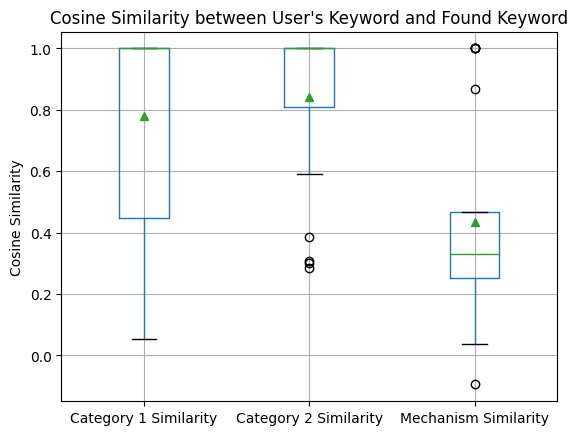

In [158]:
import matplotlib.pyplot as plt

b_plot = df.boxplot(column = ["Category 1 Similarity", "Category 2 Similarity", 
                              "Mechanism Similarity"], 
                    showmeans = True)

b_plot.set_title("Cosine Similarity between User's Keyword and Found Keyword")

b_plot.set_ylabel("Cosine Similarity")

b_plot.plot()



In [131]:
def find_accuracy(same_list):
  sum = 0
  for item in same_list:
    sum = sum + item
  sum = sum / len(same_list)

  return sum

In [135]:
print(find_accuracy(feature_same_cat1))

print(find_accuracy(feature_same_cat2))

print(find_accuracy(feature_same_mech))


0.7619047619047619
0.7619047619047619
0.23809523809523808
